### Data Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%shell
cp ./drive/MyDrive/Colab\ Notebooks/NOW/SaltDataset.zip ./sample_data/
cd ./sample_data
unzip SaltDataset.zip
rm SaltDataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: SaltDataset/train/masks/78b2d05419.png  
  inflating: __MACOSX/SaltDataset/train/masks/._78b2d05419.png  
  inflating: SaltDataset/train/masks/9678fb935e.png  
  inflating: __MACOSX/SaltDataset/train/masks/._9678fb935e.png  
  inflating: SaltDataset/train/masks/2b723b8474.png  
  inflating: __MACOSX/SaltDataset/train/masks/._2b723b8474.png  
  inflating: SaltDataset/train/masks/7e68df3981.png  
  inflating: __MACOSX/SaltDataset/train/masks/._7e68df3981.png  
  inflating: SaltDataset/train/masks/851a37ac37.png  
  inflating: __MACOSX/SaltDataset/train/masks/._851a37ac37.png  
  inflating: SaltDataset/train/masks/6010b9b84d.png  
  inflating: __MACOSX/SaltDataset/train/masks/._6010b9b84d.png  
  inflating: SaltDataset/train/masks/f64190c47e.png  
  inflating: __MACOSX/SaltDataset/train/masks/._f64190c47e.png  
  inflating: SaltDataset/train/masks/ec3130dd0b.png  
  inflating: __MACOSX/SaltDataset/train/masks/._ec3130dd0b.png

In [3]:
%%shell
cd ./sample_data
# rm SaltDataset.zip
rm -r __MACOSX
rm ./SaltDataset/.DS_Store
rm ./SaltDataset/test/.DS_Store
rm ./SaltDataset/train/.DS_Store
# rm ./SaltDataset/train/images/_*
# rm ./SaltDataset/train/masks/_*

### Import Packages & Data

In [1]:
import os
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm
# from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
n_fold = 5  # ?
pad_left = 0
pad_right = 0
fine_size = 202 # ?
batch_size = 32
epochs = 1
snapshot = 6 # ? what for
max_lr = 0.012
min_lr = 0.001
momentum = 0.9
weight_decay = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

save_weight = '../rst/'

# if not os.path.isdir(save_weight):
#     os.makedirs(save_weight)
weight_name = 'model_' + str(fine_size + pad_left + pad_right)

# train_image_path = './sample_data/SaltDataset/train/images'
# train_mask_path = './sample_data/SaltDataset/train/masks'
# test_image_path = './sample_data/SaltDataset/test/images'
# train_file = './sample_data/SaltDataset/train.csv'
# depths_file = './sample_data/SaltDataset/depths.csv'
train_image_path = './data/SaltDataset/train/images'
train_mask_path = './data/SaltDataset/train/masks'
test_image_path = './data/SaltDataset/test/images'
train_file = './data/SaltDataset/train.csv'
depths_file = './data/SaltDataset/depths.csv'

Image --[GAN get latent]--> use the depth --[get feature map latent]-->

### GAN model

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(2, 2),

            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(2, 2),

            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=1),
        )

    def forward(self, img):
        out = self.encoder(img)
        return out


class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.img_shape = (((img_shape // 2) // 2) // 2) // 2
        self.linear = nn.Linear(self.img_shape ^2 * 256, 128)
        self.fc = nn.Linear(128, 1)

    def forward(self, img):
        rst = self.conv(img)
        rst = rst.view(img.shape[0], -1)
        rst = self.linear(rst)
        rst = self.fc(rst)
        return rst

In [4]:
# depths = pd.read_csv('./data/SaltDataset/depths.csv')
# depths.sort_values('z', inplace=True)
# depths.drop('z', axis=1, inplace=True)
# depths['fold'] = (list(range(0,5)) * depths.shape[0])[:depths.shape[0]]
#
# train_df = pd.read_csv('./sample_data/SaltDataset/train.csv')
train_df = pd.read_csv('./data/SaltDataset/train.csv')
len(train_df)
# train_df = train_df.merge(depths)
# dist = []
# for id in train_df.id.values:
#   img = cv2.imread(f'./data/SaltDataset/train/images/{id}.png', cv2.IMREAD_GRAYSCALE)
#   dist.append(np.unique(img).shape[0])
# train_df['unique_pixels'] = dist


4000

In [5]:
from sklearn.model_selection import train_test_split

class SaltDataset(Dataset):
    def __init__(self, img_path, mask_path, train_file, depth_file, img_size=224, mode='train', transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.train_df = pd.read_csv(train_file).drop('rle_mask', axis=1)
        self.depth_df = pd.read_csv(depth_file)
        self.train_df = self.train_df.merge(self.depth_df)
        self.img_size = img_size
        self.transform = transform
        # self.mode = mode
        # if mode == 'train':
        #     self.file_idx = list(range(len(self.train_df)))
        #     self.train_idx, self.val_idx = train_test_split(file_idx, test_size=0.2, shuffle=True)


    def __len__(self):
        return len(self.train_df)


    def __getitem__(self, idx):
        # if self.train_idx:
        #     pass
        # elif self.mode == 'val':
        #     pass
        img_path = os.path.join(self.img_path, self.train_df.values[idx, 0] + '.png')
        mask_path = os.path.join(self.mask_path, self.train_df.values[idx, 0] + '.png')
        depth = self.train_df.values[idx, 1]

        # image = read_image(img_path) # , mode=ImageReadMode.GRAY
        # mask = read_image(mask_path)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255

        image = np.resize(image, (self.img_size, self.img_size))
        mask = np.resize(mask, (self.img_size, self.img_size))


        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            # depth = self.transform(depth)

        return image, mask, depth


# def trainImageFetch(image_len):
#     image_train = np.zeros((image_len, 101, 101), dtype=np.float32) / 255
#     mask_train = np.zeros((image_len, 101, 101), dtype=np.float32) / 255

# depths = pd.read_csv('./data/SaltDataset/depths.csv')
# train_df = pd.read_csv('./data/SaltDataset/train.csv')
# train_df = train_df.merge(depths)       # merge 就像数据库一样合并表，主键自动匹配

# for id in train_df.id.values:
#     img = cv2.imread(f'./data/SaltDataset/train/images/{id}.png', cv2.IMREAD_GRAYSCALE)
#     dist.append(np.unique(img).shape[0])
#     # print(img.shape)
#
#
# train_df['unique_pixels'] = dist

In [6]:
dataset = SaltDataset(train_image_path, train_mask_path, train_file, depths_file, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),

]))

file_idx = list(range(train_df.shape[0]))
train_idx, val_idx = train_test_split(file_idx, test_size=0.2, shuffle=True)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
# print(training_data.__dict__)

In [7]:

# model
g_model = Generator().to(device)
d_model = Discriminator(img_shape=101).to(device)

# optimzer
G_optim = optim.SGD(g_model.parameters(), lr=min_lr, momentum=0.05)
D_optim = optim.SGD(d_model.parameters(), lr=min_lr, momentum=0.05)

# loss
g_loss = nn.MSELoss()
d_loss = nn.MSELoss()

### U-net

In [8]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class Contract(nn.Module):
    def __init__(self, in_channels, out_channels, pad=False):
        super(Contract, self).__init__()
        self.pad = pad
        self.padding = 1 if pad is True else 0
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=self.padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=self.padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pooling = nn.MaxPool2d(2, 2)

    def forward(self, x, last=False):
        height = x.shape[2]
        width = x.shape[3]
        out = self.conv1(x)
        if self.pad is False:
            out = centerCrop(out, height, width)
            # pass
            # output should be cropped here
        rst = out
        if last is False:
            rst = self.pooling(rst)
        return rst, out


class Expansion(nn.Module):
    def __init__(self, in_channels, out_channels, pad=False):
        super(Expansion, self).__init__()
        self.pad = pad
        self.padding = 1 if pad is True else 0
        self.deconv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=self.padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=self.padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, out_c, x):
        # print(x.shape)
        out = self.deconv1(x)
        # if self.pad is False:
        #     pass
        # rst = np.concatenate((out_c, out), axis=1)
        # print(out_c.shape, out.shape)

        rst = torch.cat((out_c, out), dim=1)
        rst = self.conv2(rst)
        return rst


class Unet(nn.Module):
    def __init__(self, img_channel, pad):
        super(Unet, self).__init__()
        # self.img_size = img_size
        self.imgchannel = img_channel
        self.pad = pad
        # print(self.imgshape)

        self.layer1 = Contract(self.imgchannel, 64, pad=self.pad)
        self.layer2 = Contract(64, 128, pad=self.pad)
        self.layer3 = Contract(128, 256, pad=self.pad)
        self.layer4 = Contract(256, 512, pad=self.pad)
        self.layer = Contract(512, 1024, pad=self.pad)

        self.delayer4 = Expansion(1024, 512, pad=self.pad)
        self.delayer3 = Expansion(512, 256, pad=self.pad)
        self.delayer2 = Expansion(256, 128, pad=self.pad)
        self.delayer1 = Expansion(128, 64, pad=self.pad)

        self.conv = nn.Conv2d(64, 1, kernel_size=1)


    def forward(self, img):
        out, l1 = self.layer1(img)
        out, l2 = self.layer2(out)
        out, l3 = self.layer3(out)
        out, l4 = self.layer4(out)
        out, _ = self.layer(out, last=True)

        out = self.delayer4(l4, out)
        out = self.delayer3(l3, out)
        out = self.delayer2(l2, out)
        out = self.delayer1(l1, out)

        rst = self.conv(out)
        return rst

def centerCrop(x, height, width):
    crop_h = torch.FloatTensor([x.size()[2]]).sub(height).div(-2)    # means {(x.size()[2] or xheight) - height} / 2
    crop_w = torch.FloatTensor([x.size()[3]]).sub(width).div(-2)
    # print(crop_w, crop_h)
    rst = F.pad(x, (crop_w.ceil().int()[0], crop_w.floor().int()[0], crop_h.ceil().int()[0], crop_h.floor().int()[0]))
    return rst

In [9]:
# from U_net import Unet

model = Unet(1, pad=True).to(device)
U_optim = optim.SGD(model.parameters(), lr=min_lr, momentum=0.05)
u_loss = nn.BCELoss()

In [10]:
# model.count_params()
total_params = sum(p.numel() for p in model.parameters())
trainable_params: int = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params, trainable_params)

31042369 31042369


In [11]:
# np.round(0.5)
# torch.cuda.empty_cache()

In [12]:
# print(train_loader.dataset.__getitem__(0))

def train(dataloader, model, epochs):
    pass

# train discriminator
for epoch in range(epochs):
    for idx, (imgs, masks, depths) in enumerate(train_loader, start=0):
        # print(imgs), print(masks), print(depths)
        # imgs = imgs.to(device)
        # # masks = masks.to(device)
        # pred_feature = g_model(depths)
        # pred_depth = d_model(pred_feature)
        # loss_a = d_loss(pred_depth, depths)
        # loss_b = d_loss(imgs, depths)
        # loss = (loss_a + loss_b) / 2
        #
        # # optimizer.zero
        # G_optim.zero_grad()
        # D_optim.zero_grad()
        #
        # #
        # loss.backward()
        # D_optim.step()
        # G_optim.step()
        #
        # print(f"Pred_depth: {pred_depth}\tloss_a: {loss_a}\tloss_b: {loss_b}\tTotal Loss: {loss}")
        imgs = imgs.to(device)
        masks = masks.to(device)
        # preds = torch.round(model(imgs))
        preds = model(imgs) #.to('cpu').numpy()
        preds = F.sigmoid(preds)
        # print(preds)
        # plabels = [1 if i > 0 else 0 for i in preds]
        loss = u_loss(preds, masks)

        U_optim.zero_grad()
        loss.backward()
        U_optim.step()
        print(f"loss: {loss}")

/Users/bling/opt/anaconda3/envs/cv/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.7012823224067688
loss: 0.6730133295059204
loss: 0.6583644151687622
loss: 0.6662048697471619
loss: 0.6704767942428589
loss: 0.6488293409347534
loss: 0.6438384056091309
loss: 0.6540030837059021
loss: 0.6721978187561035
loss: 0.6661266684532166
loss: 0.6444464325904846
loss: 0.6587530374526978
loss: 0.6677538156509399
loss: 0.6504149436950684
loss: 0.6727355122566223
loss: 0.6313924789428711
loss: 0.6353543996810913
loss: 0.6504466533660889
loss: 0.6411561965942383
loss: 0.6670547723770142
loss: 0.6485057473182678
loss: 0.6502118110656738
loss: 0.6351603865623474
loss: 0.6511359810829163
loss: 0.6438764333724976
loss: 0.650017499923706
loss: 0.6519365310668945
loss: 0.6606820821762085
loss: 0.673748254776001
loss: 0.6712982654571533
loss: 0.6420198678970337
loss: 0.638512909412384
loss: 0.6459218859672546
loss: 0.6241617202758789
loss: 0.6280590891838074
loss: 0.6398640275001526
loss: 0.6281355023384094
loss: 0.635547399520874
loss: 0.6510294079780579
loss: 0.6411519050598145
loss

In [26]:
a = torch.randn((3,3))
# a
torch.ones_like(a)
a[0, 0] = 0
a

tensor([[ 0.0000,  1.8264, -0.3681],
        [ 0.4157,  1.1481, -1.7949],
        [-0.3200,  1.1501,  0.6048]])

In [35]:
pred_img_list = []
mask_list = []
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda')

def test(model, val_loader):
    model.eval()
    count = 0
    avg_loss = 0
    with torch.no_grad():
        for idx, (imgs, masks, depths) in enumerate(val_loader, start=0):
            imgs = imgs.to(device)
            # print(1)
            masks = masks.to(device)
            preds = model(imgs) # .to('cpu').numpy()
            preds = F.sigmoid(preds)
            predict = torch.where(preds > 0.5,1,0)
            print(predict)
            pred_img_list.append(predict)
            mask_list.append(masks)
            loss = u_loss(preds, masks)
            print(f"loss: {loss}")
            count = count + 1
            avg_loss = avg_loss + loss
    print(avg_loss / count)

test(model, val_loader)

/Users/bling/opt/anaconda3/envs/cv/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[[[0, 0, 0,  ..., 0, 1, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 1],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        ...,


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
         

tensor([[0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])


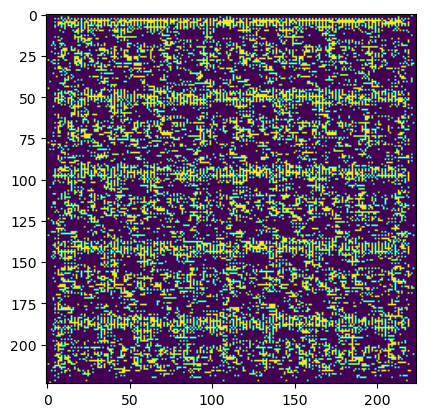

In [36]:
print(pred_img_list[0][7][0])
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(pred_img_list[0][7][0].cpu().numpy())

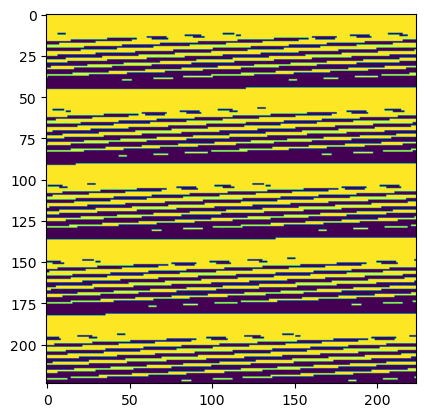

In [37]:
plt.figure()
plt.imshow(mask_list[0][7][0].cpu().numpy())

In [ ]:
def do_kaggle_metric(predict,truth, threshold=0.5):

    N = len(predict)
    predict = predict.reshape(N,-1)
    truth   = truth.reshape(N,-1)

    predict = predict>threshold
    truth   = truth>0.5
    intersection = truth & predict
    union        = truth | predict
    iou = intersection.sum(1)/(union.sum(1)+1e-8)

    #-------------------------------------------
    result = []
    precision = []
    is_empty_truth   = (truth.sum(1)==0)
    is_empty_predict = (predict.sum(1)==0)

    threshold = np.array([0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
    for t in threshold:
        p = iou>=t

        tp  = (~is_empty_truth)  & (~is_empty_predict) & (iou> t)
        fp  = (~is_empty_truth)  & (~is_empty_predict) & (iou<=t)
        fn  = (~is_empty_truth)  & ( is_empty_predict)
        fp_empty = ( is_empty_truth)  & (~is_empty_predict)
        tn_empty = ( is_empty_truth)  & ( is_empty_predict)

        p = (tp + tn_empty) / (tp + tn_empty + fp + fp_empty + fn)

        result.append( np.column_stack((tp,fp,fn,tn_empty,fp_empty)) )
        precision.append(p)

    result = np.array(result).transpose(1,2,0)
    precision = np.column_stack(precision)
    precision = precision.mean(1)

    return precision, result, threshold